# Imports

I have yet to find a way to get ipycanvas working on colab.

In [1]:
import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io


# Thread Management

In [2]:
class Cleanup():
    """The purpose of this is to keep track of all the threads I run, and terminate
    them with reset or hard_reset."""
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        """Keep a list of active threads"""
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        """Threads with a while loop terminate according to a variable called isalive.
        This will terminate all running threads, but raise an exception with threads 
        that have not started yet"""
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        """This makes sure all threads have been started then terminates them."""
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

# Collision Step

In the collision step each cell is moved towards an equilibrium based on the cell's velocity components
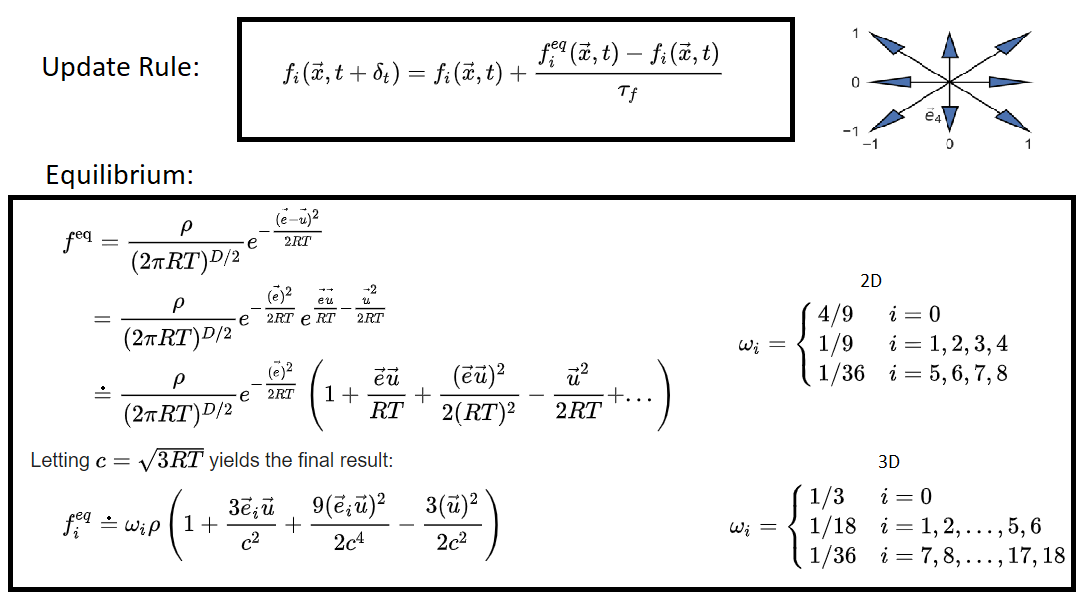

In [104]:
    
@cuda.jit(device=True)
def feq(x,y,ux,uy,w,p,c2):
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    dot=(x*ux+y*uy)*3/c2
    return w*p*(1+dot+dot**2/2-3*(ux*ux+uy*uy)/(2*c2))

@cuda.jit
def collision2D(grid,viscosity,c):
    i,j=cuda.grid(2)
    #the grid represents our velocity density function
    cell=grid[i][j]
    itau = 1/(3*viscosity + 0.5)  #reciprocal of relaxation time
    c2=c**2
    #rho is the total density given by the sum of the velocity density function
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho<=0:return
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    #velocity in x so east-west
    ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
    #velocity in y so north-south
    uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    
    #wi= 4/9 for i=0, 1/9 for w in 1-4, 1/36 for i in 5-8
    
    
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    #fi=fi+(feq-fi)/tao

    #Update move each velocity-density towards equilibrium
    cell[0]+=(feq(0,0,ux,uy,4/9,rho,c2)-cell[0])*itau
    #north
    cell[1]+=(feq(0,1,ux,uy,1/9,rho,c2)-cell[1])*itau
    #east
    cell[2]+=(feq(1,0,ux,uy,1/9,rho,c2)-cell[2])*itau
    #south
    cell[3]+=(feq(0,-1,ux,uy,1/9,rho,c2)-cell[3])*itau
    #west
    cell[4]+=(feq(-1,0,ux,uy,1/9,rho,c2)-cell[4])*itau
    #northeast
    cell[5]+=(feq(1,1,ux,uy,1/36,rho,c2)-cell[5])*itau
    #southeast
    cell[6]+=(feq(1,-1,ux,uy,1/36,rho,c2)-cell[6])*itau
    #southwest
    cell[7]+=(feq(-1,-1,ux,uy,1/36,rho,c2)-cell[7])*itau
    #northwest
    cell[8]+=(feq(-1,1,ux,uy,1/36,rho,c2)-cell[8])*itau
            

In [241]:

@cuda.jit
def collision2DFlowSpeed(grid,viscosity,c,vx,vy,K):
    i,j=cuda.grid(2)
    #the grid represents our velocity density function
    cell=grid[i][j]
    itau = 1/(3*viscosity + 0.5)  #reciprocal of relaxation time
    c2=c**2
    #rho is the total density given by the sum of the velocity density function
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho<=0:return
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    #velocity in x so east-west
    ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
    #velocity in y so north-south
    uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    
    #wi= 4/9 for i=0, 1/9 for w in 1-4, 1/36 for i in 5-8
    
    
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    #fi=fi+(feq-fi)/tao
    fy=(vy-uy)*rho/c2*K
    fx=(vx-ux)*rho/c2*K
    #Update move each velocity-density towards equilibrium
    cell[0]+=(feq(0,0,ux,uy,4/9,rho,c2)-cell[0])*itau
    #north
    cell[1]+=(feq(0,1,ux,uy,1/9,rho,c2)-cell[1])*itau+fy/9
    #east
    cell[2]+=(feq(1,0,ux,uy,1/9,rho,c2)-cell[2])*itau+fx/9
    #south
    cell[3]+=(feq(0,-1,ux,uy,1/9,rho,c2)-cell[3])*itau-fy/9
    #west
    cell[4]+=(feq(-1,0,ux,uy,1/9,rho,c2)-cell[4])*itau-fx/9
    #northeast
    cell[5]+=(feq(1,1,ux,uy,1/36,rho,c2)-cell[5])*itau+(fx+fy)/36
    #southeast
    cell[6]+=(feq(1,-1,ux,uy,1/36,rho,c2)-cell[6])*itau+(fx-fy)/36
    #southwest
    cell[7]+=(feq(-1,-1,ux,uy,1/36,rho,c2)-cell[7])*itau-(fx+fy)/36
    #northwest
    cell[8]+=(feq(-1,1,ux,uy,1/36,rho,c2)-cell[8])*itau+(-fx+fy)/36

# Streaming Step

The streaming step represents the movement of particles.
It adheres to the following updates:
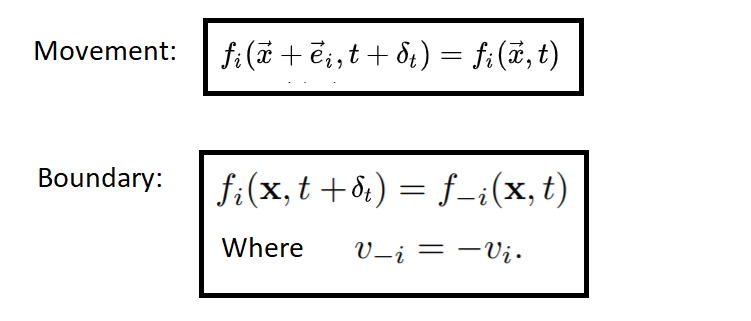

In [233]:
@cuda.jit
def streamGPU(grid,nextgrid,boundaries):
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    sx,sy,_=grid.shape
    i,j=cuda.grid(2)
    if i>=sx or j>sy:return
    if boundaries[i][j]>=0:return
    
    #no direction
    nextgrid[i][j][0]=grid[i][j][0]
    
    #north
    if boundaries[i+1-sx][j]<0:
        #move density to next cell
        nextgrid[i+1-sx][j][1]=grid[i][j][1]
    else:
        #bounce density off of boundary
        nextgrid[i][j][3]=grid[i][j][1]
    #south
    if boundaries[i-1][j]<0:
        #move density to next cell
        nextgrid[i-1][j][3]=grid[i][j][3]
    else:
        #bounce density off of boundary
        nextgrid[i][j][1]=grid[i][j][3]
    #east
    if boundaries[i][j+1-sy]<0:
        #move density to next cell
        nextgrid[i][j+1-sy][2]=grid[i][j][2]
    else:
        #bounce density off of boundary
        nextgrid[i][j][4]=grid[i][j][2]
    #west
    if boundaries[i][j-1]<0:
        #move density to next cell
        nextgrid[i][j-1][4]=grid[i][j][4]
    else:
        #bounce density off of boundary
        nextgrid[i][j][2]=grid[i][j][4]

    #northeast
    if boundaries[i+1-sx][j+1-sy]<0:
        #move density to next cell
        nextgrid[i+1-sx][j+1-sy][5]=grid[i][j][5]
    else:
        #bounce density off of boundary
        nextgrid[i][j][7]=grid[i][j][5]
    #southwest
    if boundaries[i-1][j-1]<0:
        #move density to next cell
        nextgrid[i-1][j-1][7]=grid[i][j][7]
    else:
        #bounce density off of boundary
        nextgrid[i][j][5]=grid[i][j][7]
    #northwest
    if boundaries[i+1-sx][j-1]<0:
        #move density to next cell
        nextgrid[i+1-sx][j-1][8]=grid[i][j][8]
    else:
        #bounce density off of boundary
        nextgrid[i][j][6]=grid[i][j][8]
    #southeast
    if boundaries[i-1][j+1-sy]<0:
        #move density to next cell
        nextgrid[i-1][j+1-sy][6]=grid[i][j][6]
    else:
        #bounce density off of boundary
        nextgrid[i][j][8]=grid[i][j][6]

# Helper functions to set equilibrium

In [234]:
@cuda.jit
def altcollision2D(grid,viscosity,c):
    i,j=cuda.grid(2)
    #the grid represents our velocity density function
    cell=grid[i][j]
    omega = 1.0/(3*viscosity + 0.5)  #reciprocal of relaxation time
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    n0=cell[0]
    nN=cell[1]
    nE=cell[2]
    nS=cell[3]
    nW=cell[4]
    nNE=cell[5]
    nSE=cell[6]
    nSW=cell[7]
    nNW=cell[8]
    
    thisrho = n0 + nN + nS + nE + nW + nNW + nNE + nSW + nSE;
    if thisrho<=0:return
    #rho[i] = thisrho;
    thisux = (nE + nNE + nSE - nW - nNW - nSW) / thisrho;
    #ux[i] = thisux;
    thisuy = (nN + nNE + nNW - nS - nSE - nSW) / thisrho;
    #uy[i] = thisuy
    one9thrho = thisrho/9.0;     #pre-compute a bunch of stuff for optimization
    one36thrho = thisrho/36.0;
    ux3 = 3 * thisux;
    uy3 = 3 * thisuy;
    ux2 = thisux * thisux;
    uy2 = thisuy * thisuy;
    uxuy2 = 2 * thisux * thisuy;
    u2 = ux2 + uy2;
    u215 = 1.5 * u2;
    cell[0]  += omega * (4.0/9.0*thisrho * (1                        - u215) - n0);
    cell[1]  += omega * (   one9thrho * (1 + uy3       + 4.5*uy2        - u215) - nN);
    cell[2]  += omega * (   one9thrho * (1 + ux3       + 4.5*ux2        - u215) - nE);
    cell[3] += omega * (   one9thrho * (1 - uy3       + 4.5*uy2        - u215) - nS);
    cell[4]  += omega * (   one9thrho * (1 - ux3       + 4.5*ux2        - u215) - nW);
    cell[5] += omega * (  one36thrho * (1 + ux3 + uy3 + 4.5*(u2+uxuy2) - u215) - nNE);
    cell[6] += omega * (  one36thrho * (1 + ux3 - uy3 + 4.5*(u2-uxuy2) - u215) - nSE);
    cell[7] += omega * (  one36thrho * (1 - ux3 - uy3 + 4.5*(u2+uxuy2) - u215) - nSW);
    cell[8] += omega * (  one36thrho * (1 - ux3 + uy3 + 4.5*(u2-uxuy2) - u215) - nNW);

    

@cuda.jit
def setEquil(grid,boundaries,newux, newuy, newrho):
    """Sets each cell to an equilibrium speed and density"""
    i,j=cuda.grid(2)
    if boundaries[i][j]>=0:return
    cell=grid[i][j]
    
    ux3 = 3 * newux;
    uy3 = 3 * newuy;
    ux2 = newux * newux;
    uy2 = newuy * newuy;
    uxuy2 = 2 * newux * newuy;
    u2 = ux2 + uy2;
    u215 = 1.5 * u2;
    four9ths=4.0/9.0
    one9th=1.0/9.0
    one36th=1.0/36.0
    cell[0]  = four9ths * newrho * (1                              - u215); #n0
    cell[2]  =   one9th * newrho * (1 + ux3       + 4.5*ux2        - u215);#nE
    cell[4]  =   one9th * newrho * (1 - ux3       + 4.5*ux2        - u215);#nW
    cell[1]  =   one9th * newrho * (1 + uy3       + 4.5*uy2        - u215);#nN
    cell[3]  =   one9th * newrho * (1 - uy3       + 4.5*uy2        - u215);#nS
    cell[5] =  one36th * newrho * (1 + ux3 + uy3 + 4.5*(u2+uxuy2) - u215);#nNE
    cell[6] =  one36th * newrho * (1 + ux3 - uy3 + 4.5*(u2-uxuy2) - u215);#nSE
    cell[8] =  one36th * newrho * (1 - ux3 + uy3 + 4.5*(u2-uxuy2) - u215);#nNW
    cell[7] =  one36th * newrho * (1 - ux3 - uy3 + 4.5*(u2+uxuy2) - u215);#nSW

@cuda.jit
def setwall(grid,u0):
    """Sets left side to equilibrium at x-velocity u0"""
    i=cuda.grid(1)
    four9ths=4.0/9.0
    one9th=1.0/9.0
    one36th=1.0/36.0
    #ordering is zero,n ,e ,s ,w ,ne,se,sw,nw
    #             0   1  2  3  4  5  6  7  8
    grid[i][0][2] = one9th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)   #nE[:,0]
    grid[i][0][4] = one9th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)   #nW[:,0]
    grid[i][0][5] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)#nNE[:,0]
    grid[i][0][6] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)#nSE[:,0]
    grid[i][0][8] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)#nNW[:,0]
    grid[i][0][7] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)#nSW[:,0]

In [235]:
test=np.random.random([4,10,9])

test2=test.copy()


visc=np.random.random()/5+0.05
print(test[-1,-1],visc)
print("################################")
altcollision2D[(1,1),(4,10)](test,visc,1)
print(test[-1,-1])
print("################################")

collision2D[(1,1),(4,10)](test2,visc,1)
print(test2[-1,-1])

print(np.sum(abs(test-test2)))

[0.66269365 0.2192114  0.29002828 0.56073358 0.52901305 0.62781707
 0.27464983 0.90401858 0.29015636] 0.17192205290307408
################################
[1.82022725 0.29922482 0.3146436  0.69977232 0.66665678 0.06616213
 0.12339659 0.25633677 0.11190157]
################################
[1.82022725 0.29922482 0.3146436  0.69977232 0.66665678 0.06616213
 0.12339659 0.25633677 0.11190157]
2.3897550605056495e-14


# Rendering

In [236]:
@cuda.jit
def jetRGBArrow(data,image,min_,max_,V):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap"""
    i,j=cuda.grid(2)
    R=16
    
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    Red=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    Red+=(gij>0.66)&(gij<0.89)
    Red+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    Green=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    Green+=(gij>0.375)&(gij<0.64)
    Green+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    Blue=(gij<0.11)*(0.5+gij/0.22)
    Blue+=(gij>0.11)&(gij<0.34)
    Blue+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0


    A=1.0;
    R=16
    ri=int(math.floor(i/R/2)*2*R+R)
    rj=int(math.floor(j/R/2)*2*R+R)
    #//coordintates of potential vector arrow this is part of
    
    #//for(let i1=0;i1<9;i1++){
    #//ri=(Math.floor(i/R/2+i1/3-1)*2*R+R)%512
    #//rj=(Math.floor(j/R/2+i1%3-1)*2*R+R)%512
        
    #//vector representing the field arrow
    dx=(R-7)*V[ri][rj][1]/max_[0]**0.5
    dy=(R-7)*V[ri][rj][0]/max_[0]**0.5
    m=(R-7)*((data[ri][rj])/max_[0])**0.5
    #dx=dy=m*0.707
    hs=min(m,3.5)
    #//now we check if our pixel is inside the arrow
    if (m>0):
        x = i-ri
        y=j-rj
        #//arrowhead can be done using inf and 1 norm in rotated coords
        X = dx*(dy-y)/m - dy*(dx-x)/m
        Y = dy*(dy-y)/m + dx*(dx-x)/m
        
        #// A<=0 if its in the arrowhead, 0<A<1 if its on the border A>1 if outside.
        A=min(A,max(-(hs-1.5*abs(X)-0.5*abs(Y)), -(hs-abs(Y+hs))));
        
        #//arrow body done by looking at length of orthogonal (to E field) part of pixel vector
        d=x*dx+y*dy
        X = x-d*dx/m/m
        Y = y-d*dy/m/m       
        if (d<m*m):
            #//Same assignment here but with the arrow body
            A=min(A,max(-3*d/hs,1-(hs/3.2-(X*X+Y*Y)**0.5)/0.4))
        #//clip A between 0 and 1
        A=max(A,0)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A

In [253]:
import glob
from PIL import Image as PImage

@cuda.jit
def upscale(inarr,outarr):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    outarr[i][j]=inarr[i//iscale][j//jscale][0]
@cuda.jit
def density(inarr,outarr,min_,max_,V):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    cell=inarr[i//iscale][j//jscale]
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho>0:
        ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
        #velocity in y so north-south
        uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    else:
        ux=uy=0
    outarr[i][j]=(ux*ux+uy*uy)
    V[i][j][0]=ux
    V[i][j][1]=uy
    cuda.atomic.max(max_,0,outarr[i][j])
    cuda.atomic.min(min_,0,outarr[i][j])
@cuda.jit
def jetRGB(data,image,min_,max_):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap"""
    i,j=cuda.grid(2)
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    R=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    R+=(gij>0.66)&(gij<0.89)
    R+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    G=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    G+=(gij>0.375)&(gij<0.64)
    G+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    B=(gij<0.11)*(0.5+gij/0.22)
    B+=(gij>0.11)&(gij<0.34)
    B+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0
    image[i][j][0]=R*255
    image[i][j][1]=G*255
    image[i][j][2]=B*255
class Render(Thread):
    def __init__(self, globalmem, canvas,dim=[512,512]):
        self.upscaled=cuda.to_device(np.zeros(dim))
        self.img=np.zeros(dim+[3])
        self.threads=(16,16)
        self.blocks=(int(np.ceil(dim[0] / 16)),int(np.ceil(dim[1] / 16)))
        self.grid_global_mem = globalmem
        
        self.V=cuda.to_device(np.zeros(dim+[2],dtype=np.float32))
        
        self.canvas = canvas
        self.isalive=True
        self.min=cuda.to_device(np.ones(1)*9999.9)
        self.max=cuda.to_device(np.ones(1)*-9999.9)
        super(Render, self).__init__()
    def run(self):
        allframes=[]
        while self.isalive:
            density[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max,self.V)
            jetRGBArrow[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max,self.V)
            self.min,self.max=self.max,self.min
            image_data = self.img
            self.canvas.put_image_data(image_data, 0, 0)
            allframes+=[PImage.fromarray(image_data.astype('uint8'))]
            time.sleep(0.01)
            
        fp_out = "Demo.gif"
        img, *imgs = allframes
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=20, loop=0)
    def debug(self):
            density[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max)
            #jetRGB[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max)
            time.sleep(0.01)
            print(self.max[0],self.min[0])
            self.min,self.max=self.max,self.min
            
            
            
            
class Fluid(Thread):
    def __init__(self, N,maxsteps=1e6):
        #setup the lattice and helper data structures
        self.N=N
        self.maxsteps=maxsteps
        height = N
        width = N*2
        viscosity = 0.2
        omega = 1 / (3*viscosity + 0.5)     # "relaxation" parameter
        self.u0=u0 = 0.1                            # initial and in-flow speed
        four9ths = 4.0/9.0                  # abbreviations for lattice-Boltzmann weight factors
        one9th   = 1.0/9.0
        one36th  = 1.0/36.0

        # Initialize all the arrays to steady rightward flow:
        n0 = four9ths * (np.ones((height,width)) - 1.5*u0**2)	# particle densities along 9 directions
        nN = one9th * (np.ones((height,width)) - 1.5*u0**2)
        nS = one9th * (np.ones((height,width)) - 1.5*u0**2)
        nE = one9th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nW = one9th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nNE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nSE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nNW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nSW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

        GRID=np.zeros([N,2*N,9])
        GRID[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
        print(GRID.shape)

        barrier = np.zeros((height,width))-1
        barrier[(height//2)-8:(height//2)+8, height//2] = 1
        #barrier[0,:]=1
        #barrier[-1,:]=1
        GRID[barrier>=0]=0
        
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(GRID.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(GRID.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        self.grid1 = cuda.to_device(GRID)
        self.grid2=cuda.to_device(GRID.copy())
        self.c=1
        self.v=0.2
        self.bounds=cuda.to_device(barrier)
        self.vx=self.vy=0
        self.fakeforce=True
        
        super(Fluid, self).__init__()
    def fps(self):
        """Gives the number of updates performed in one second"""
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        """Run the ising updates on a thread"""
        self.index=0
        #setEquil[self.blockspergrid, self.threadsperblock](self.grid1,self.bounds,0, 0.1, 1)
        while self.isalive and self.index<self.maxsteps:
            
            self.index+=1
            if self.fakeforce:
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid1,self.grid2,self.bounds)
                collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid2,self.v,self.c,self.vx,self.vy,5e-3)
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid2,self.grid1,self.bounds)
                collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid1,self.v,self.c,self.vx,self.vy,5e-3)
                
            else:
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid1,self.grid2,self.bounds)
                collision2D[self.blockspergrid, self.threadsperblock](self.grid2,self.v,self.c)
                setwall[1,self.N](self.grid2,self.vx)
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid2,self.grid1,self.bounds)
                collision2D[self.blockspergrid, self.threadsperblock](self.grid1,self.v,self.c)
                setwall[1,self.N](self.grid1,self.vx)
cleaner.hard_reset()    
model = Fluid(128)
print(model.blockspergrid, model.threadsperblock)
canvas = Canvas(width=1024,height=512)
rend = Render(model.grid1,canvas,dim=[512,1024])
cleaner.add(model,rend)
model.start()
rend.start()


def func(Temp,Viscosity,Row,Theta):
    model.c=Temp
    model.v=Viscosity
    model.vx=np.cos(Theta*2*np.pi)*Row
    model.vy=np.sin(Theta*2*np.pi)*Row
    
plswork = widgets.Layout(
    width='50%'
)
    
x = widgets.FloatSlider(min=1,max=2,value=1.0,step=0.001,layout=plswork)
x.style.handle_color = 'lightblue'
y = widgets.FloatSlider(min=0.005,value=0.2,max=0.5,step=0.0001,layout=plswork)
z = widgets.FloatSlider(min=0,value=0.0,max=1,step=0.0001,layout=plswork)
w = widgets.FloatSlider(min=0,value=0.1,max=0.1,step=0.0001,layout=plswork)
widgets.interact(func,Temp=x,Viscosity=y,Row=w,Theta=z)

canvas

(128, 256, 9)
(8, 16) (16, 16)


interactive(children=(FloatSlider(value=1.0, description='Temp', layout=Layout(width='50%'), max=2.0, min=1.0,…

Canvas(height=512, width=1024)

In [249]:
model.fakeforce=True

In [213]:
rend.debug()
model.fps()

TypeError: Failed in nopython mode pipeline (step: fix up args)
Signature mismatch: 4 argument types given, but function takes 5 arguments

In [254]:
print(model.fps())
cleaner.hard_reset()

277


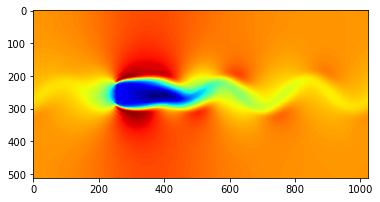

In [239]:
plt.imshow(rend.V.copy_to_host()[:,:,0],cmap='jet')
plt.show()

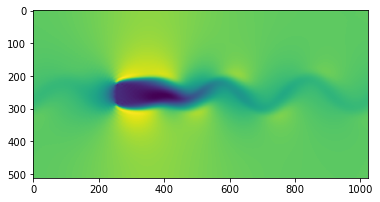

0.09344523400068283 -2.2542631086253095e-06


In [240]:
V=rend.V.copy_to_host()
ux=V[:,:,0]
uy=V[:,:,1]
plt.imshow(ux)
plt.show()
print(np.sum(ux)/ux.size,np.sum(uy)/uy.size)

# CPU Stream and Collide functions using numpy

In [30]:
def collide2DCPU(grid,viscosity):
    n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW=grid.transpose([2,0,1])
    omega = 1 / (3*viscosity + 0.5)
    
    rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
    ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
    uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
    ux2 = ux * ux				# pre-compute terms used repeatedly...
    uy2 = uy * uy
    u2 = ux2 + uy2
    omu215 = 1 - 1.5*u2			# "one minus u2 times 1.5"
    uxuy = ux * uy
    n0 = (1-omega)*n0 + omega * four9ths * rho * omu215
    nN = (1-omega)*nN + omega * one9th * rho * (omu215 + 3*uy + 4.5*uy2)
    nS = (1-omega)*nS + omega * one9th * rho * (omu215 - 3*uy + 4.5*uy2)
    nE = (1-omega)*nE + omega * one9th * rho * (omu215 + 3*ux + 4.5*ux2)
    nW = (1-omega)*nW + omega * one9th * rho * (omu215 - 3*ux + 4.5*ux2)
    nNE = (1-omega)*nNE + omega * one36th * rho * (omu215 + 3*(ux+uy) + 4.5*(u2+2*uxuy))
    nNW = (1-omega)*nNW + omega * one36th * rho * (omu215 + 3*(-ux+uy) + 4.5*(u2-2*uxuy))
    nSE = (1-omega)*nSE + omega * one36th * rho * (omu215 + 3*(ux-uy) + 4.5*(u2-2*uxuy))
    nSW = (1-omega)*nSW + omega * one36th * rho * (omu215 + 3*(-ux-uy) + 4.5*(u2+2*uxuy))
    
    grid[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])

    
def streamCPU(grid):
    n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW=grid.transpose([2,0,1])
    nN  = np.roll(nN,   1, axis=0)	# axis 0 is north-south; + direction is north
    nNE = np.roll(nNE,  1, axis=0)
    nNW = np.roll(nNW,  1, axis=0)
    nS  = np.roll(nS,  -1, axis=0)
    nSE = np.roll(nSE, -1, axis=0)
    nSW = np.roll(nSW, -1, axis=0)
    nE  = np.roll(nE,   1, axis=1)	# axis 1 is east-west; + direction is east
    nNE = np.roll(nNE,  1, axis=1)
    nSE = np.roll(nSE,  1, axis=1)
    nW  = np.roll(nW,  -1, axis=1)
    nNW = np.roll(nNW, -1, axis=1)
    nSW = np.roll(nSW, -1, axis=1)
    # Use tricky boolean arrays to handle barrier collisions (bounce-back):
    nN[barrierN] = nS[barrier]
    nS[barrierS] = nN[barrier]
    nE[barrierE] = nW[barrier]
    nW[barrierW] = nE[barrier]
    nNE[barrierNE] = nSW[barrier]
    nNW[barrierNW] = nSE[barrier]
    nSE[barrierSE] = nNW[barrier]
    nSW[barrierSW] = nNE[barrier]
    grid[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])

def U(grid):
    n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW=grid.transpose([2,0,1])
    
    rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
    ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
    uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
    return ux,uy

 LatticeBoltzmannDemo.py:  a two-dimensional lattice-Boltzmann "wind tunnel" simulation
 Uses np to speed up all array handling.
 Uses matplotlib to plot and animate the curl of the macroscopic velocity field.

 Copyright 2013, Daniel V. Schroeder (Weber State University) 2013

 Permission is hereby granted, free of charge, to any person obtaining a copy of 
 this software and associated data and documentation (the "Software"), to deal in 
 the Software without restriction, including without limitation the rights to 
 use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
 of the Software, and to permit persons to whom the Software is furnished to do 
 so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in all 
 copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
 INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
 PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR 
 ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR 
 OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
 OTHER DEALINGS IN THE SOFTWARE.

 Except as contained in this notice, the name of the author shall not be used in 
 advertising or otherwise to promote the sale, use or other dealings in this 
 Software without prior written authorization.

 Credits:
 The "wind tunnel" entry/exit conditions are inspired by Graham Pullan's code
 (http://www.many-core.group.cam.ac.uk/projects/LBdemo.shtml).  Additional inspiration from 
 Thomas Pohl's applet (http://thomas-pohl.info/work/lba.html).  Other portions of code are based 
 on Wagner (http://www.ndsu.edu/physics/people/faculty/wagner/lattice_boltzmann_codes/) and
 Gonsalves (http://www.physics.buffalo.edu/phy411-506-2004/index.html; code adapted from Succi,
 http://global.oup.com/academic/product/the-lattice-boltzmann-equation-9780199679249).

 For related materials see http://physics.weber.edu/schroeder/fluids

(64, 128, 9)
0.010000000000000004
0.010000000000000004


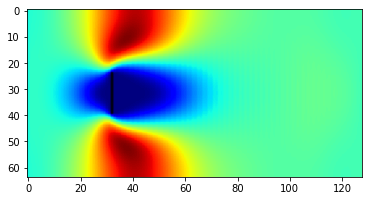

In [62]:
import time,matplotlib.pyplot, matplotlib.animation

# Define constants:
height = 64							# lattice dimensions
width = 128
viscosity = 0.2					# fluid viscosity
omega = 1 / (3*viscosity + 0.5)		# "relaxation" parameter
u0 = 0.1							# initial and in-flow speed
four9ths = 4.0/9.0					# abbreviations for lattice-Boltzmann weight factors
one9th   = 1.0/9.0
one36th  = 1.0/36.0
performanceData = False				# set to True if performance data is desired

# Initialize all the arrays to steady rightward flow:
n0 = four9ths * (np.ones((height,width)) - 1.5*u0**2)	# particle densities along 9 directions
nN = one9th * (np.ones((height,width)) - 1.5*u0**2)
nS = one9th * (np.ones((height,width)) - 1.5*u0**2)
nE = one9th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nW = one9th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

GRID=np.zeros([64,128,9])
GRID[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
print(GRID.shape)
#collision2D[(4,8),(16,16)](GRID,0.02,1)

n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW=GRID.transpose([2,0,1])

#collision2D[(4,8),(16,16)](GRID,viscosity,1)



rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW		# macroscopic density
ux = (nE + nNE + nSE - nW - nNW - nSW) / rho				# macroscopic x velocity
uy = (nN + nNE + nNW - nS - nSE - nSW) / rho				# macroscopic y velocity

print(np.max(ux*ux+uy*uy))

# Initialize barriers:
barrier = np.zeros((height,width), bool)					# True wherever there's a barrier
barrier[(height//2)-8:(height//2)+8, height//2] = True			# simple linear barrier
barrierN = np.roll(barrier,  1, axis=0)					# sites just north of barriers
barrierS = np.roll(barrier, -1, axis=0)					# sites just south of barriers
barrierE = np.roll(barrier,  1, axis=1)					# etc.
barrierW = np.roll(barrier, -1, axis=1)
barrierNE = np.roll(barrierN,  1, axis=1)
barrierNW = np.roll(barrierN, -1, axis=1)
barrierSE = np.roll(barrierS,  1, axis=1)
barrierSW = np.roll(barrierS, -1, axis=1)



# Move all particles by one step along their directions of motion (pbc):
def stream():
    global nN, nS, nE, nW, nNE, nNW, nSE, nSW
    nN  = np.roll(nN,   1, axis=0)	# axis 0 is north-south; + direction is north
    nNE = np.roll(nNE,  1, axis=0)
    nNW = np.roll(nNW,  1, axis=0)
    nS  = np.roll(nS,  -1, axis=0)
    nSE = np.roll(nSE, -1, axis=0)
    nSW = np.roll(nSW, -1, axis=0)
    nE  = np.roll(nE,   1, axis=1)	# axis 1 is east-west; + direction is east
    nNE = np.roll(nNE,  1, axis=1)
    nSE = np.roll(nSE,  1, axis=1)
    nW  = np.roll(nW,  -1, axis=1)
    nNW = np.roll(nNW, -1, axis=1)
    nSW = np.roll(nSW, -1, axis=1)
    # Use tricky boolean arrays to handle barrier collisions (bounce-back):
    nN[barrierN] = nS[barrier]
    nS[barrierS] = nN[barrier]
    nE[barrierE] = nW[barrier]
    nW[barrierW] = nE[barrier]
    nNE[barrierNE] = nSW[barrier]
    nNW[barrierNW] = nSE[barrier]
    nSE[barrierSE] = nNW[barrier]
    nSW[barrierSW] = nNE[barrier]

# Collide particles within each cell to redistribute velocities (could be optimized a little more):
def collide():
    global rho, ux, uy, n0, nN, nS, nE, nW, nNE, nNW, nSE, nSW
    rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
    ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
    uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
    ux2 = ux * ux				# pre-compute terms used repeatedly...
    uy2 = uy * uy
    u2 = ux2 + uy2
    omu215 = 1 - 1.5*u2			# "one minus u2 times 1.5"
    uxuy = ux * uy
    n0 = (1-omega)*n0 + omega * four9ths * rho * omu215
    nN = (1-omega)*nN + omega * one9th * rho * (omu215 + 3*uy + 4.5*uy2)
    nS = (1-omega)*nS + omega * one9th * rho * (omu215 - 3*uy + 4.5*uy2)
    nE = (1-omega)*nE + omega * one9th * rho * (omu215 + 3*ux + 4.5*ux2)
    nW = (1-omega)*nW + omega * one9th * rho * (omu215 - 3*ux + 4.5*ux2)
    nNE = (1-omega)*nNE + omega * one36th * rho * (omu215 + 3*(ux+uy) + 4.5*(u2+2*uxuy))
    nNW = (1-omega)*nNW + omega * one36th * rho * (omu215 + 3*(-ux+uy) + 4.5*(u2-2*uxuy))
    nSE = (1-omega)*nSE + omega * one36th * rho * (omu215 + 3*(ux-uy) + 4.5*(u2-2*uxuy))
    nSW = (1-omega)*nSW + omega * one36th * rho * (omu215 + 3*(-ux-uy) + 4.5*(u2+2*uxuy))
    # Force steady rightward flow at ends (no need to set 0, N, and S components):
    nE[:,0] = one9th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nW[:,0] = one9th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nNE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nSE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nNW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
    nSW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

# Compute curl of the macroscopic velocity field:
def curl(ux, uy):
    return np.roll(uy,-1,axis=1) - np.roll(uy,1,axis=1) - np.roll(ux,-1,axis=0) + np.roll(ux,1,axis=0)




    #frameName = "frame%04d.png" % arg
    #matplotlib.pyplot.savefig(frameName)
    #frameList.write(frameName + '\n')
for step in range(200):# adjust number of steps for smooth animation
    if step%200==0:
        print(np.max(ux**2+uy**2))
    #print(np.min(ux**2+uy**2))
    stream()

    #GRID[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
    #streamGPU[(4,8),(16,16)](GRID.copy(),GRID,barrier*2-1)
    #collision2D[(4,8),(16,16)](GRID,viscosity,1)
    #collide2DCPU(GRID,viscosity)
    #ux,uy=U(GRID)
    #n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW=GRID.transpose([2,0,1])

    collide()

plt.imshow((ux**2+uy**2), origin='lower', cmap='jet')
plt.imshow(np.stack([barrier*0.0]*3+[barrier*0.9],axis=2))
plt.show()

# Comparison of CPU and GPU LBM

(64, 128, 9)


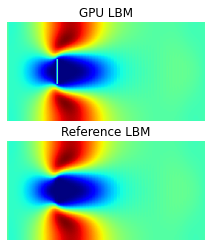

Difference (not including boundary):  6.078313893875809e-11


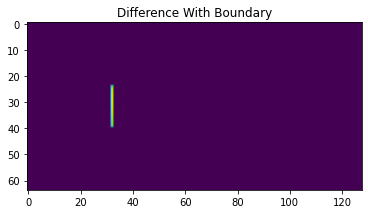

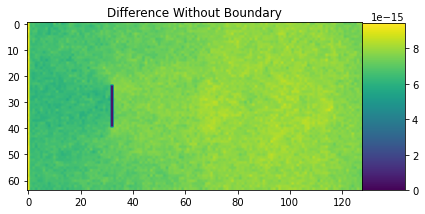

In [63]:
model=Fluid(64,100)
model.run()
g1=model.grid1.copy_to_host()
g2=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
fig,(ax1,ax2)=plt.subplots(2,1)
ax1.imshow(sum(np.array(U(g1))**2),cmap='jet')
ax1.set_title("GPU LBM")
ax1.axis('off')
#plt.show()
ax2.imshow(sum(np.array(U(g2))**2),cmap='jet')
ax2.set_title("Reference LBM")
ax2.axis('off')
plt.show()

print("Difference (not including boundary): ",np.sum(abs(g2-g1)*(~barrier.reshape(64,128,1))))


plt.imshow(np.sum(abs(g2-g1),axis=2))
plt.title("Difference With Boundary")
plt.show()

plt.imshow(np.sum(abs(g2-g1),axis=2)*(~barrier))
plt.title("Difference Without Boundary")
cax = plt.axes([0.9, 0.21, 0.1, 0.58])
plt.colorbar(cax=cax)
plt.show()